/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Recommended Distribution Centers:
1. Location: Odisha_Industrial_Area_1
   Total cost: 450640.96
   Latitude: 20.4719
   Longitude: 84.7123
   Land Cost: 81221.93 INR/sq ft
   Labor Cost: 8330.01 INR/day
   Electricity Cost: 116.05 INR/unit
   Risk Factor: 3.46
   Cumulative Demand: 773.70

2. Location: Andaman and Nicobar Islands_Industrial_Area_1
   Total cost: 594193.67
   Latitude: 11.9402
   Longitude: 92.7493
   Land Cost: 165261.21 INR/sq ft
   Labor Cost: 10837.47 INR/day
   Electricity Cost: 100.37 INR/unit
   Risk Factor: 3.44
   Cumulative Demand: 766.17

3. Location: Goa_Industrial_Area_5
   Total cost: 743287.25
   Latitude: 14.9191
   Longitude: 73.7533
   Land Cost: 152303.44 INR/sq ft
   Labor Cost: 15610.36 INR/day
   Electricity Cost: 118.94 INR/unit
   Risk Factor: 3.74
   Cumulative Demand: 859.36



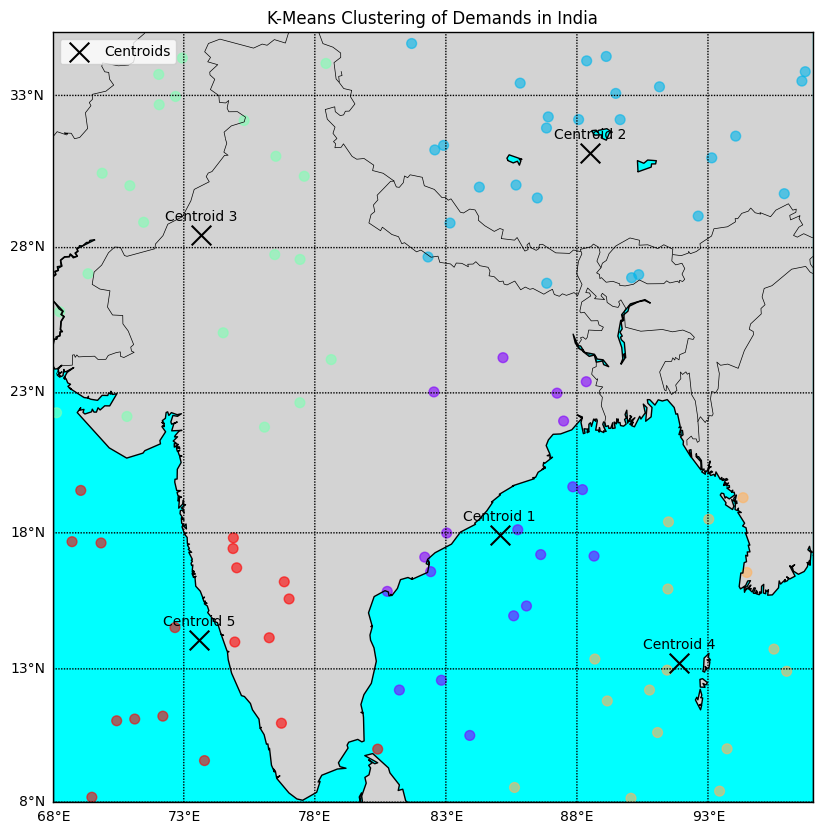

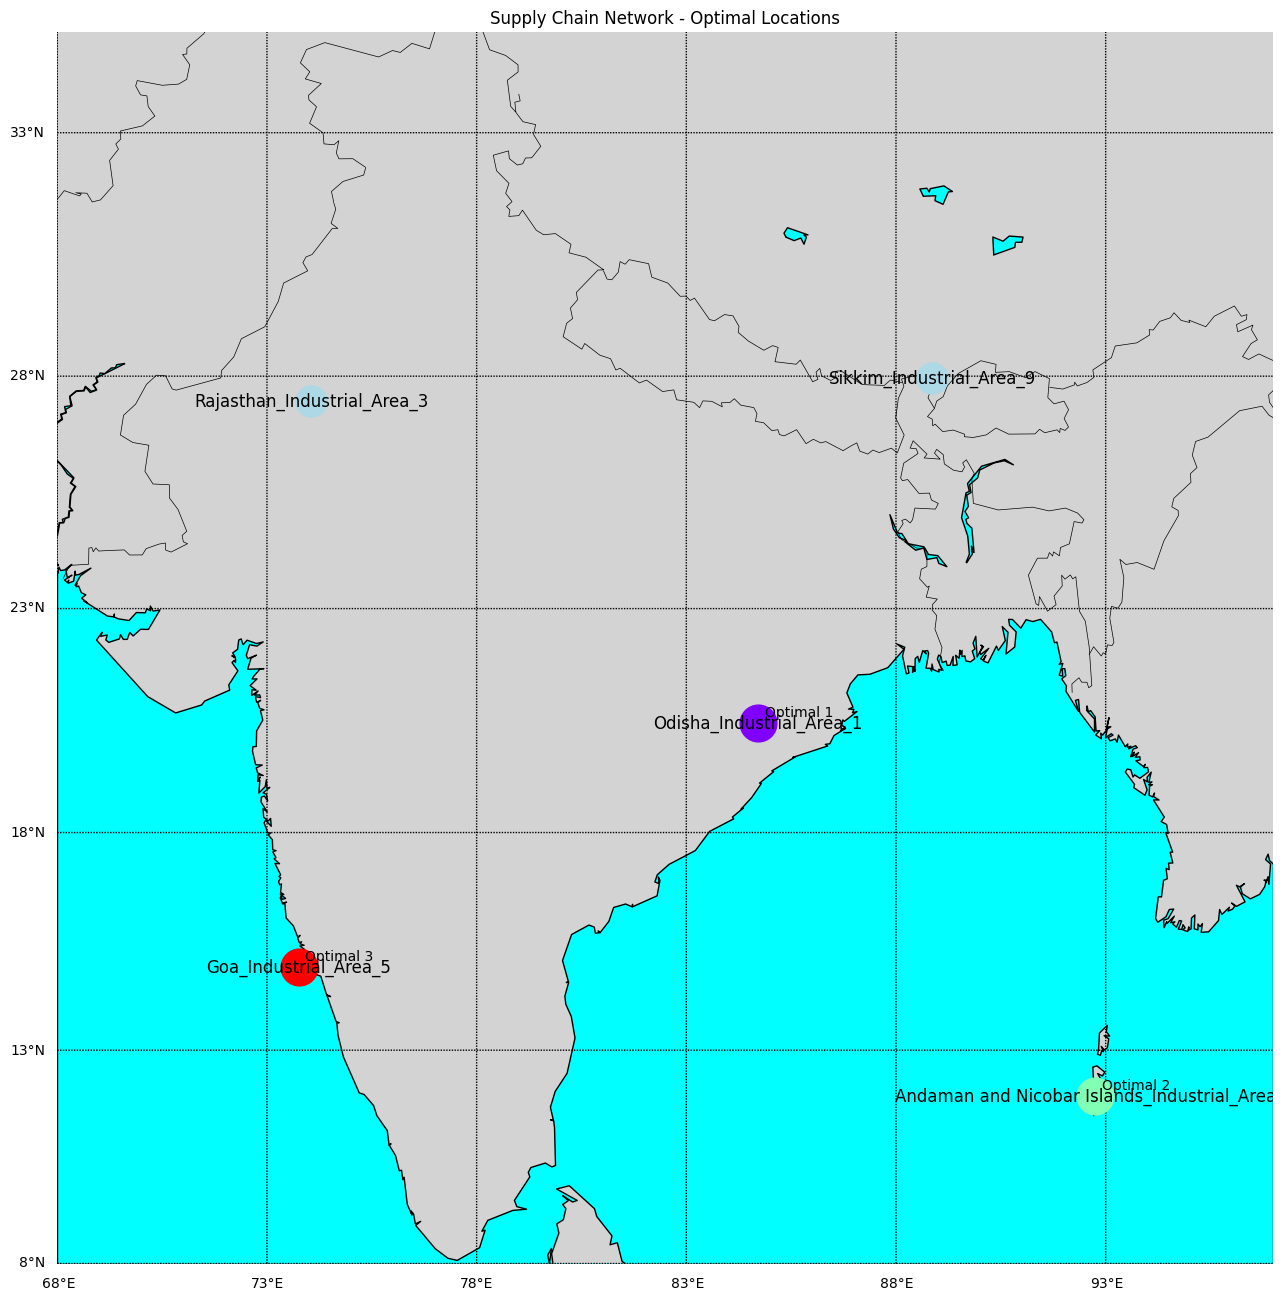


Details of All Recommended Nodes:
Location: Odisha_Industrial_Area_1
   Latitude: 20.4719
   Longitude: 84.7123
   Land Cost: 81221.93 INR/sq ft
   Labor Cost: 8330.01 INR/day
   Electricity Cost: 116.05 INR/unit
   Risk Factor: 3.46
   Cumulative Demand: 773.70

Location: Sikkim_Industrial_Area_9
   Latitude: 27.9665
   Longitude: 88.8693
   Land Cost: 323655.17 INR/sq ft
   Labor Cost: 26711.72 INR/day
   Electricity Cost: 155.23 INR/unit
   Risk Factor: 5.00
   Cumulative Demand: 1255.87

Location: Rajasthan_Industrial_Area_3
   Latitude: 27.4797
   Longitude: 74.0578
   Land Cost: 165838.15 INR/sq ft
   Labor Cost: 22513.83 INR/day
   Electricity Cost: 153.05 INR/unit
   Risk Factor: 4.17
   Cumulative Demand: 995.15

Location: Andaman and Nicobar Islands_Industrial_Area_1
   Latitude: 11.9402
   Longitude: 92.7493
   Land Cost: 165261.21 INR/sq ft
   Labor Cost: 10837.47 INR/day
   Electricity Cost: 100.37 INR/unit
   Risk Factor: 3.44
   Cumulative Demand: 766.17

Location: Goa_

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx
from scipy.spatial.distance import cdist
from mpl_toolkits.basemap import Basemap

# Load the dataset
df = pd.read_csv("indian_industrial_areas_dataset_combined.csv")

# Generate random clusters within India
np.random.seed(42)
n_clusters = 5
n_points_per_cluster = 20
clusters = []
demands = []

for _ in range(n_clusters):
    cluster_lat = np.random.uniform(8, 35, n_points_per_cluster)
    cluster_lon = np.random.uniform(68, 97, n_points_per_cluster)
    cluster_demand = np.random.uniform(1, 100, n_points_per_cluster)
    clusters.append(np.column_stack((cluster_lat, cluster_lon)))
    demands.append(cluster_demand)

clusters = np.vstack(clusters)
demands = np.concatenate(demands)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(clusters)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Calculate cumulative demands for each centroid
cumulative_demands = []
for i in range(n_clusters):
    cluster_demands = demands[cluster_labels == i]
    cumulative_demands.append(np.sum(cluster_demands))

# Find nearest industrial areas to centroids
def find_nearest_industrial_area(centroid, df):
    distances = cdist([centroid], df[['Latitude', 'Longitude']])
    nearest_index = distances.argmin()
    return df.iloc[nearest_index]

nearest_areas = [find_nearest_industrial_area(centroid, df) for centroid in centroids]

# Create a supply chain network
G = nx.Graph()

# Add nodes (nearest industrial areas) to the graph
for i, area in enumerate(nearest_areas):
    demand = cumulative_demands[i]
    land_cost = area['Land Cost (INR/sq ft)'] * demand * 0.1
    labor_cost = area['Labour Cost (INR/day)'] * demand * 0.05
    electricity_cost = area['Electricity Cost (INR/unit)'] * demand * 0.02
    risk_factor = 1 + (demand / max(cumulative_demands)) * 4  # Scale risk from 1 to 5

    G.add_node(area['Industrial Area'],
               land_cost=land_cost,
               labor_cost=labor_cost,
               electricity_cost=electricity_cost,
               risk_factor=risk_factor,
               lat=area['Latitude'],
               lon=area['Longitude'],
               demand=demand)

# Function to find optimal locations
def find_optimal_locations(G, num_optimal=3):
    cost_matrix = []
    for node in G.nodes():
        # Calculate total cost based on node attributes
        total_cost = (G.nodes[node]['land_cost'] +
                      G.nodes[node]['labor_cost'] * 30 +  # Assume 30 days of labor
                      G.nodes[node]['electricity_cost'] * 1000 +  # Assume 1000 units of electricity
                      G.nodes[node]['risk_factor'] * 1000)  # Weight for risk factor

        cost_matrix.append((node, total_cost))

    # Find the optimal nodes (lowest total costs)
    optimal_nodes = sorted(cost_matrix, key=lambda x: x[1])[:num_optimal]

    return optimal_nodes

# Find and print the optimal locations
optimal_locations = find_optimal_locations(G, num_optimal=3)

print("\nRecommended Distribution Centers:")
for i, (location, cost) in enumerate(optimal_locations, 1):
    print(f"{i}. Location: {location}")
    print(f"   Total cost: {cost:.2f}")
    print(f"   Latitude: {G.nodes[location]['lat']:.4f}")
    print(f"   Longitude: {G.nodes[location]['lon']:.4f}")
    print(f"   Land Cost: {G.nodes[location]['land_cost']:.2f} INR/sq ft")
    print(f"   Labor Cost: {G.nodes[location]['labor_cost']:.2f} INR/day")
    print(f"   Electricity Cost: {G.nodes[location]['electricity_cost']:.2f} INR/unit")
    print(f"   Risk Factor: {G.nodes[location]['risk_factor']:.2f}")
    print(f"   Cumulative Demand: {G.nodes[location]['demand']:.2f}")
    print()

# Plot the K-Means clusters with the Indian map background
plt.figure(figsize=(12, 10))
m = Basemap(projection='merc', llcrnrlat=8, urcrnrlat=35, llcrnrlon=68, urcrnrlon=97, resolution='l')
m.drawmapboundary(fill_color='aqua')
m.drawcountries()
m.drawcoastlines()
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawparallels(np.arange(8., 36., 5.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(68., 98., 5.), labels=[0,0,0,1], fontsize=10)

x, y = m(clusters[:, 1], clusters[:, 0])
m.scatter(x, y, c=cluster_labels, cmap='rainbow', marker='o', alpha=0.6, s=50)
cx, cy = m(centroids[:, 1], centroids[:, 0])
m.scatter(cx, cy, c='black', marker='x', s=200, label='Centroids')

for i, (lon, lat) in enumerate(centroids):
    plt.annotate(f'Centroid {i+1}', (cx[i], cy[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title("K-Means Clustering of Demands in India")
plt.legend()
plt.show()

# Plot the supply chain network with the Indian map background
plt.figure(figsize=(20, 16))
m = Basemap(projection='merc', llcrnrlat=8, urcrnrlat=35, llcrnrlon=68, urcrnrlon=97, resolution='l')
m.drawmapboundary(fill_color='aqua')
m.drawcountries()
m.drawcoastlines()
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawparallels(np.arange(8., 36., 5.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(68., 98., 5.), labels=[0,0,0,1], fontsize=10)

pos = {node: m(G.nodes[node]['lon'], G.nodes[node]['lat']) for node in G.nodes()}
nx.draw(G, pos, node_color='lightblue', node_size=500, with_labels=True, ax=plt.gca())

colors = plt.cm.rainbow(np.linspace(0, 1, len(optimal_locations)))

# Draw optimal locations
for i, (location, _) in enumerate(optimal_locations):
    nx.draw_networkx_nodes(G, pos, nodelist=[location], node_color=[colors[i]], node_size=700)
    plt.annotate(f'Optimal {i+1}', pos[location], xytext=(5, 5), textcoords='offset points')

plt.title("Supply Chain Network - Optimal Locations")
plt.show()

# Print details for all recommended nodes
print("\nDetails of All Recommended Nodes:")
for node in G.nodes():
    print(f"Location: {node}")
    print(f"   Latitude: {G.nodes[node]['lat']:.4f}")
    print(f"   Longitude: {G.nodes[node]['lon']:.4f}")
    print(f"   Land Cost: {G.nodes[node]['land_cost']:.2f} INR/sq ft")
    print(f"   Labor Cost: {G.nodes[node]['labor_cost']:.2f} INR/day")
    print(f"   Electricity Cost: {G.nodes[node]['electricity_cost']:.2f} INR/unit")
    print(f"   Risk Factor: {G.nodes[node]['risk_factor']:.2f}")
    print(f"   Cumulative Demand: {G.nodes[node]['demand']:.2f}")
    print()
